In [191]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import datetime

## Use this DF from here on with the filled Price

In [192]:
df = pd.read_csv(
    './data/Modelar_UH2021_filled_precio.txt', parse_dates=[1], index_col=0
)

/home/muriel/.local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [193]:
df_est = pd.read_csv(
    './data/Estimar_UH2021_filled_precio.txt', parse_dates=[1], index_col=0
)

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [194]:
df

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
0,2015-06-01,21972,0,C,75.0,No Rotura,5.84,0,0,5241.0,0
1,2015-06-01,23910,5,C,170.0,No Rotura,6.07,0,0,5241.0,3
2,2015-06-01,24306,13,A,46.0,No Rotura,7.85,0,0,NaN,0
3,2015-06-01,24306,13,A,46.0,No Rotura,7.85,0,0,NaN,0
4,2015-06-01,27144,15,E,230.0,No Rotura,6.12,0,0,4064.0,0
...,...,...,...,...,...,...,...,...,...,...,...
4045017,2016-09-30,457416,1395,F,336.0,No Rotura,50.38,0,0,130.0,9
4045018,2016-09-30,457422,1080,F,336.0,Rotura,93.77,0,0,130.0,0
4045019,2016-09-30,458650,1385,K,340.0,No Rotura,70.85,0,0,126.0,0
4045020,2016-09-30,458660,1915,K,340.0,No Rotura,68.49,0,0,126.0,24


# Feature engineering

In [ ]:
df=df.drop_duplicates()

conditions = [ (df["estado"] == 'No Rotura'), (df["estado"] == 'Transito'), (df["estado"] == 'Rotura') ]
values = [1, 0, -1]
df["estado_num"] = np.select(conditions, values)

df["weekday"] = df["fecha"].dt.weekday
df["antiguedad"] = df["antiguedad"].astype('Int64')
df["antiguedad_std"] = df["antiguedad"]-df["antiguedad"].min()
df["categoria_dos"] = df["categoria_dos"].astype("Int64")

df = df.drop(columns=["estado", "antiguedad"])

In [ ]:
df_est=df_est.drop_duplicates()

conditions = [ (df_est["estado"] == 'No Rotura'), (df_est["estado"] == 'Transito') ]
values = [1, 0]
df_est["estado_num"] = np.select(conditions, values)

df_est["weekday"] = df_est["fecha"].dt.weekday
df_est["antiguedad"] = pd.to_numeric(df_est["antiguedad"], errors='coerce') 
df_est["antiguedad"] = df_est["antiguedad"].astype('Int64')
df_est["antiguedad_std"] = df_est["antiguedad"]-df_est["antiguedad"].min()
df_est["categoria_dos"] = pd.to_numeric(df_est["categoria_dos"], errors='coerce') 
df_est["categoria_dos"] = df_est["categoria_dos"].astype("Int64")

df_est = df_est.drop(columns=["estado", "antiguedad"])

In [372]:
print(df.columns)
print(df_est.columns)

Index(['fecha', 'id', 'visitas', 'categoria_uno', 'categoria_dos', 'precio',
       'dia_atipico', 'campaña', 'unidades_vendidas', 'estado_num', 'weekday',
       'antiguedad_std'],
      dtype='object')
Index(['fecha', 'id', 'visitas', 'categoria_uno', 'categoria_dos', 'precio',
       'dia_atipico', 'campaña', 'estado_num', 'weekday', 'antiguedad_std'],
      dtype='object')


# Periodicitat i variació setmanal

[(0.0, 8.0)]

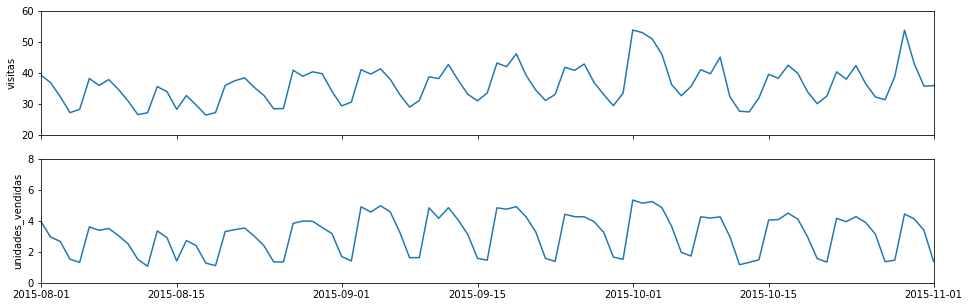

In [381]:
data_sum_total = df.groupby('fecha').sum().sort_values('fecha')
data_mean_total = df.groupby('fecha').mean().sort_values('fecha')
data_est_mean_total = df_est.groupby('fecha').mean().sort_values('fecha')

fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=[16,5])

axs[0].set(ylabel="visitas")
axs[1].set(ylabel="unidades_vendidas")

axs[0].plot(data_mean_total["visitas"])
axs[1].plot(data_mean_total["unidades_vendidas"])

axs[0].set(xlim=(datetime.datetime(2015,8,1),datetime.datetime(2015,11,1)))
axs[1].set(xlim=(datetime.datetime(2015,8,1),datetime.datetime(2015,11,1)))
axs[0].set(ylim=(20,60))
axs[1].set(ylim=(0,8))

In [198]:
weekday_sum_total = df.groupby('weekday').sum().sort_values('weekday')
weekday_mean_total = df.groupby('weekday').mean().sort_values('weekday')

<BarContainer object of 7 artists>

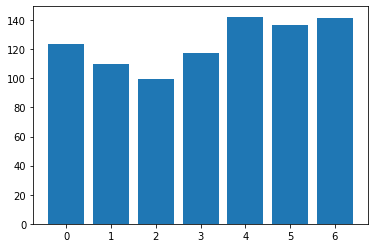

In [199]:
plt.bar(weekday_mean_total.index, weekday_mean_total["visitas"])

<BarContainer object of 7 artists>

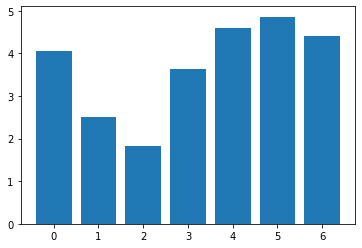

In [200]:
plt.bar(weekday_mean_total.index, weekday_mean_total["unidades_vendidas"])

<AxesSubplot:xlabel='weekday'>

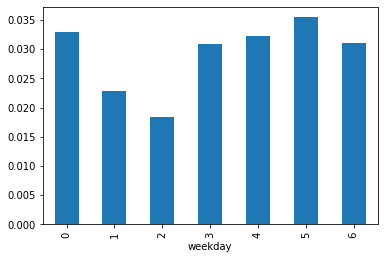

In [229]:
# Ràtio entre la mitjana de vendes i la mitjana de visites per dia de la setmana
(weekday_mean_total["unidades_vendidas"]/weekday_mean_total["visitas"]).plot(kind="bar")

# Categories

In [202]:
list_categoria_uno = sorted(df["categoria_uno"].unique())
print("Total categoria_uno:", len(list_categoria_uno))
print("Total categoria_dos:", len(df["categoria_dos"].unique()),)

suma_categories = 0
for index in range(len(df["categoria_uno"].unique())):
    print("\nCategoria uno", list_categoria_uno[index], "\nNúmero de categorias dos:", 
          len(df["categoria_dos"][df["categoria_uno"] == list_categoria_uno[index]].unique()))
    print( df["categoria_dos"][df["categoria_uno"] == list_categoria_uno[index]].unique() )
    suma_categories += len(df["categoria_dos"][df["categoria_uno"] == list_categoria_uno[index]].unique())

suma_categories

Total categoria_uno: 13
Total categoria_dos: 183

Categoria uno A 
Número de categorias dos: 35
<IntegerArray>
[ 46, 263,  34, 103, 271,  69, 338, 304,  16, 286, 137,  43, 127, 343,  23,
 197, 236, 145,  85,  82, 295, 255, 188, 282,  37,  28,  67, 342, 245, 238,
 237, 201, NaN, 242, 133]
Length: 35, dtype: Int64

Categoria uno B 
Número de categorias dos: 5
<IntegerArray>
[224, 312, 92, 153, 57]
Length: 5, dtype: Int64

Categoria uno C 
Número de categorias dos: 12
<IntegerArray>
[75, 170, 157, 63, 76, 66, 65, 72, 160, 73, 161, 158]
Length: 12, dtype: Int64

Categoria uno D 
Número de categorias dos: 1
<IntegerArray>
[264]
Length: 1, dtype: Int64

Categoria uno E 
Número de categorias dos: 57
<IntegerArray>
[230, 266, 319, 277,  10, 305, 179, 143, 105, 276,  30,  93, 323, 202, 150,
 144, 233,  78, 109,  49, 315, 267, 135,  80, 156,  51, 200, 186,  50, 285,
 NaN,  44, 108, 122, 308,  22, 273, 314, 152, 274, 216, 229, 248, 175, 115,
 249,  32, 205, 114, 247, 125, 268, 124, 171, 199, 275,

186

<AxesSubplot:>

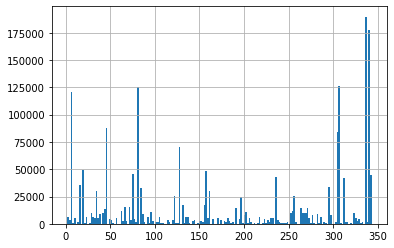

In [203]:
df["categoria_dos"].hist(bins=183)

### Productes en cada categoria_uno

In [205]:
# Primer agrupo per categories i després per productes
agrupat_productes = df.groupby(["categoria_uno", "id"]).sum().sort_values(["categoria_uno", "categoria_dos"])
agrupat_productes

visitas  categoria_dos    precio  dia_atipico  campaña  \
categoria_uno id                                                               
A             212250    83246              0  24243.12           31        0   
              78776     22401           7792  14126.67           31        0   
              79966     28395           7792  10594.72           31        0   
              80536     42451           7792  18521.50           31        0   
              82496     20668           7792   7176.19           31        0   
...                       ...            ...       ...          ...      ...   
O             357394   160524         110062  30262.58           31        0   
              402568    54675         110062  25931.00           31        0   
              309898    26053         110966  11454.15           35        4   
              346202   201658         111192  27863.19           36        5   
              346162   144208         111418  22351.14           37        6   

                      antiguedad  unidades_vendidas  estado_num  weekday  
categoria_uno id                                                          
A             212250      565894               1506         480     1459  
              78776            0                432         -50     1459  
              79966      1553530               1056         474     1459  
              80536      1662618                492         451     1459  
              82496      1473662                999         248     1459  
...                          ...                ...         ...      ...  
O             357394           0                924         165     1459  
              402568      121750                372         452     1459  
              309898      325042                579         358     1468  
              346202      219432               1542         325     1471  
              346162           0               1197         253     1476  

[4168 rows x 9 columns]

[('A', 678847.0),
 ('B', 51662.0),
 ('C', 163670.0),
 ('D', 3911.0),
 ('E', 161012.0),
 ('F', 280477.0),
 ('G', 84512.0),
 ('H', 199699.0),
 ('I', 36668.0),
 ('K', 320434.0),
 ('L', 53277.0),
 ('N', 4387.0)]

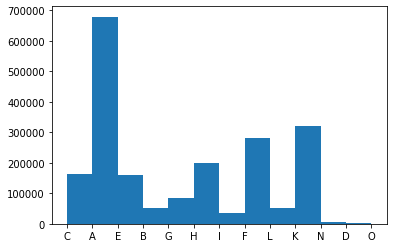

In [206]:
items_in_categoria = plt.hist(df.categoria_uno, bins=12)[0]
sorted(list(zip(df["categoria_uno"].unique(),items_in_categoria)))

### Visitas y unidades vendidas por categorías

In [379]:
list_categoria_uno = np.sort(df["categoria_uno"].unique())
list_categoria_uno

data_sum = [None]*len(list_categoria_uno)
data_mean = [None]*len(list_categoria_uno)
data_est_mean = [None]*len(list_categoria_uno)
for index in range(len(list_categoria_uno)):
    data_sum[index] = df[df["categoria_uno"] == 
                         list_categoria_uno[index]].groupby('fecha').sum().sort_values('fecha')
    data_mean[index] = df[df["categoria_uno"] == 
                         list_categoria_uno[index]].groupby('fecha').mean().sort_values('fecha')

    data_est_mean[index] = df_est[df_est["categoria_uno"] == 
                         list_categoria_uno[index]].groupby('fecha').mean().sort_values('fecha')

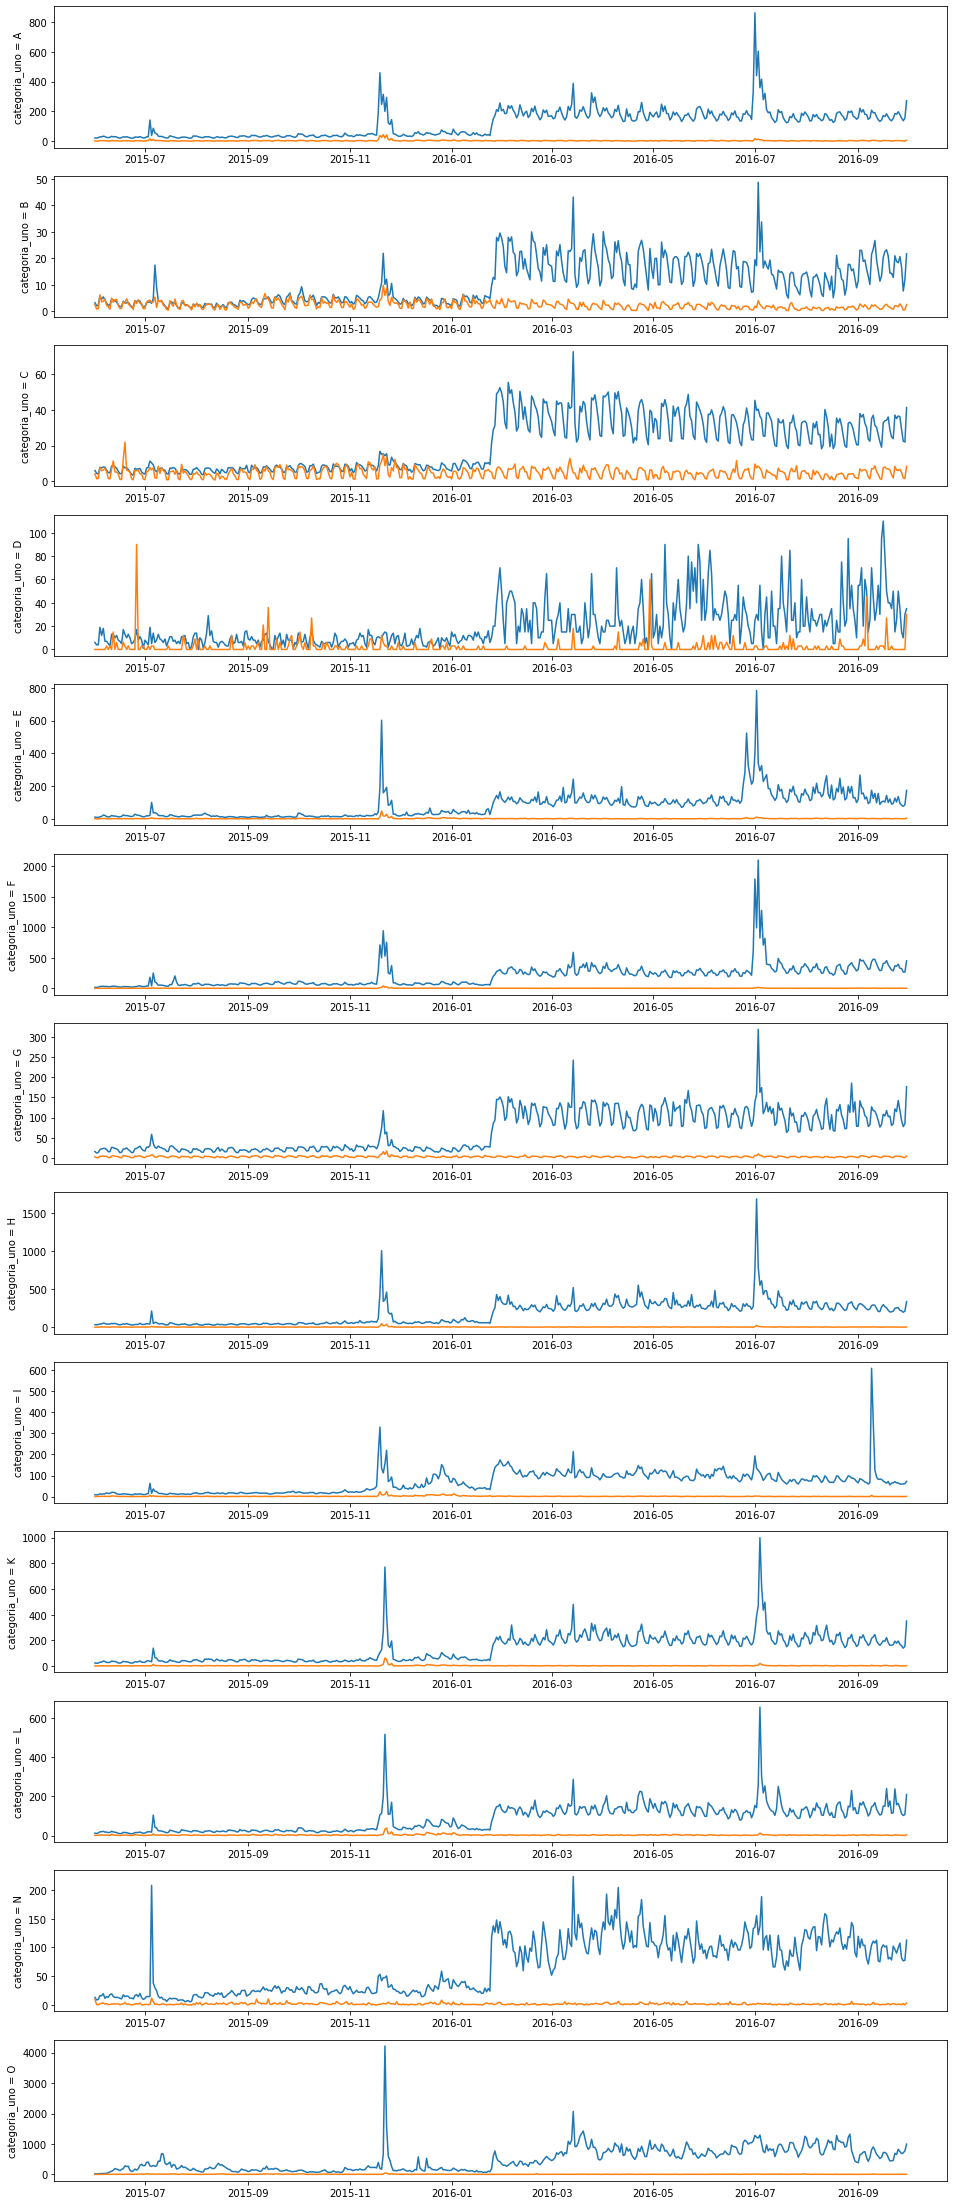

In [374]:
# Mitjana per dia
fig, axs = plt.subplots(figsize=(16,40), nrows=len(list_categoria_uno), ncols=1) #, gridspec_kw=dict(hspace=0.4))
for index in range(len(list_categoria_uno)):
    axs[index].plot(data_mean[index]["visitas"])
    axs[index].plot(data_mean[index]["unidades_vendidas"])
    axs[index].set(ylabel="categoria_uno = "+list_categoria_uno[index])
#    axs[index].set(xlim=(datetime.datetime(2016,1,15),datetime.datetime(2016,2,8)))

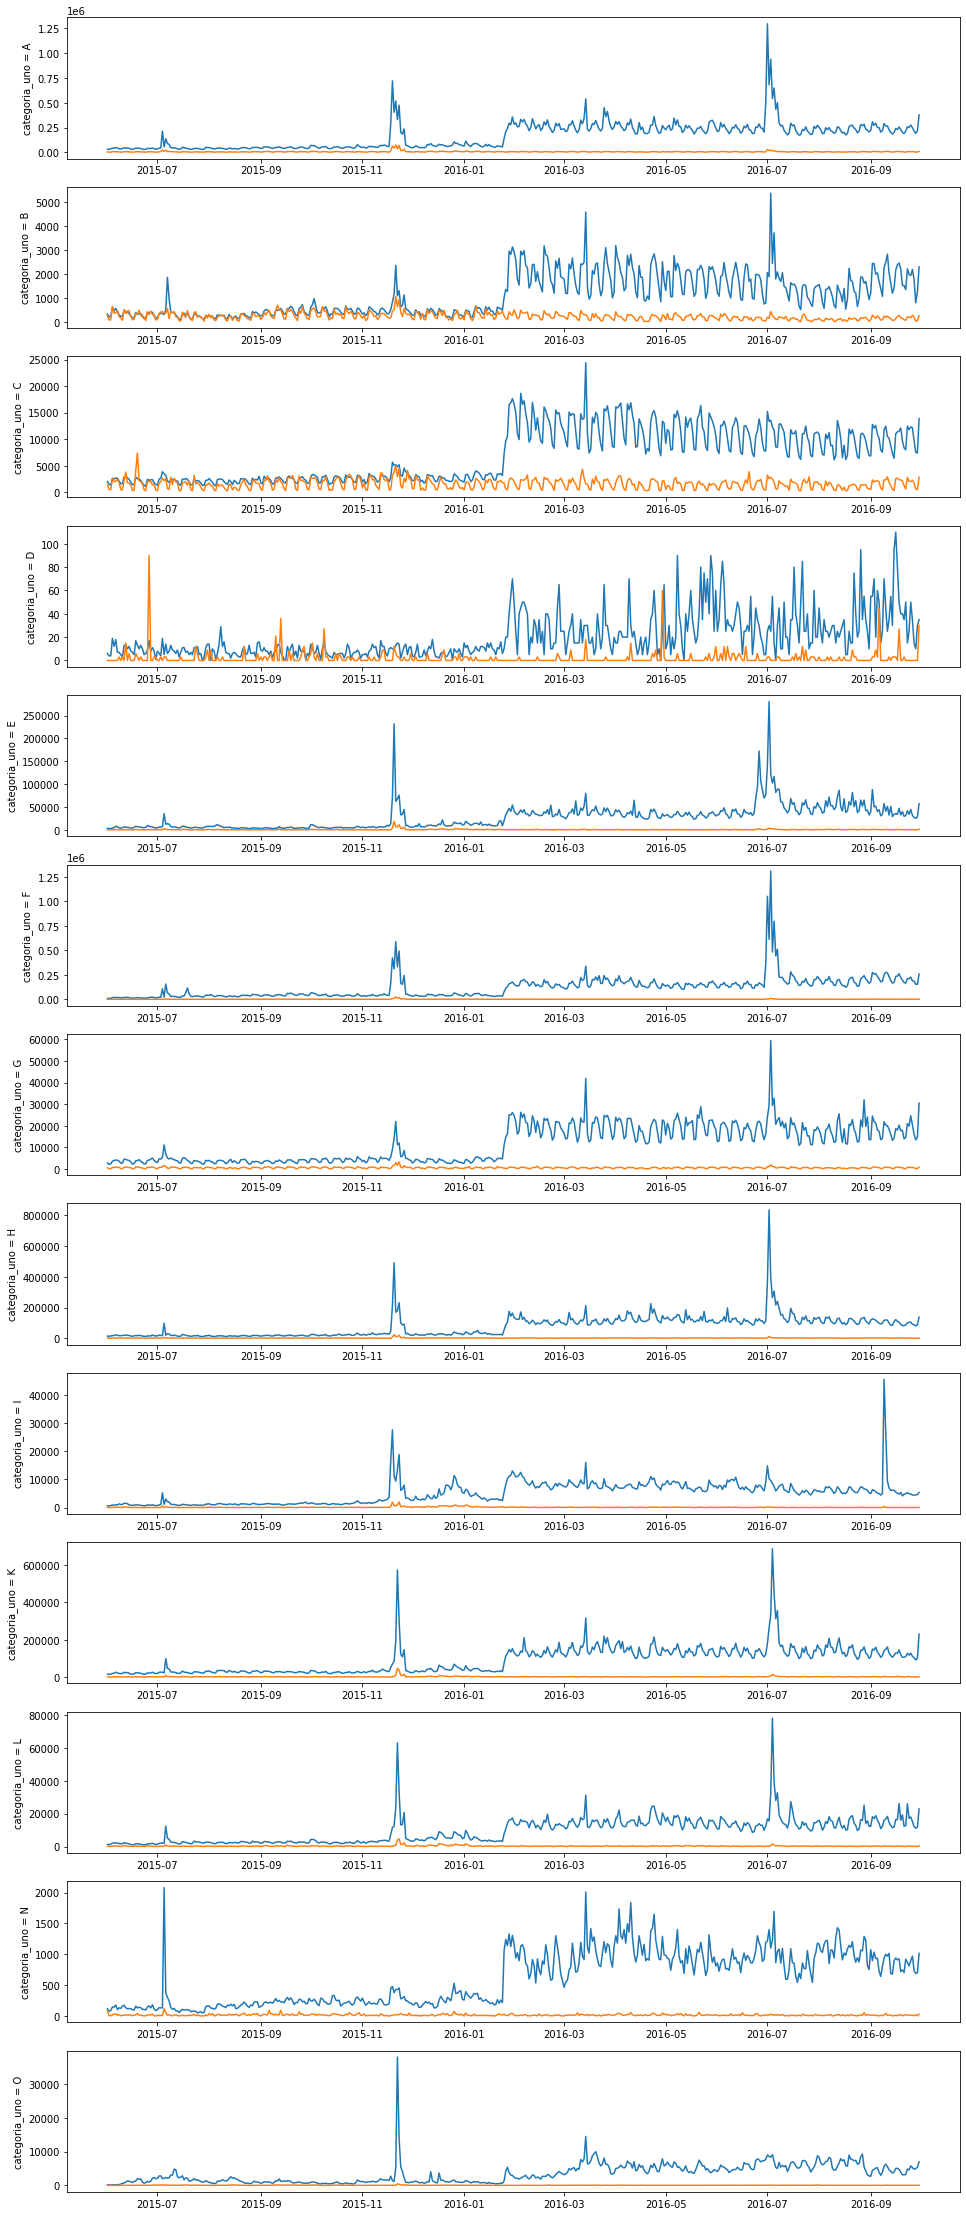

In [208]:
# Suma per dia
fig, axs = plt.subplots(figsize=(16,40), nrows=len(list_categoria_uno), ncols=1) #, gridspec_kw=dict(hspace=0.4))
for index in range(len(list_categoria_uno)):
    axs[index].plot(data_sum[index]["visitas"])
    axs[index].plot(data_sum[index]["unidades_vendidas"])
    axs[index].set(ylabel="categoria_uno = "+list_categoria_uno[index])
#    axs[index].set(xlim=(datetime.datetime(2016,1,15),datetime.datetime(2016,2,8)))

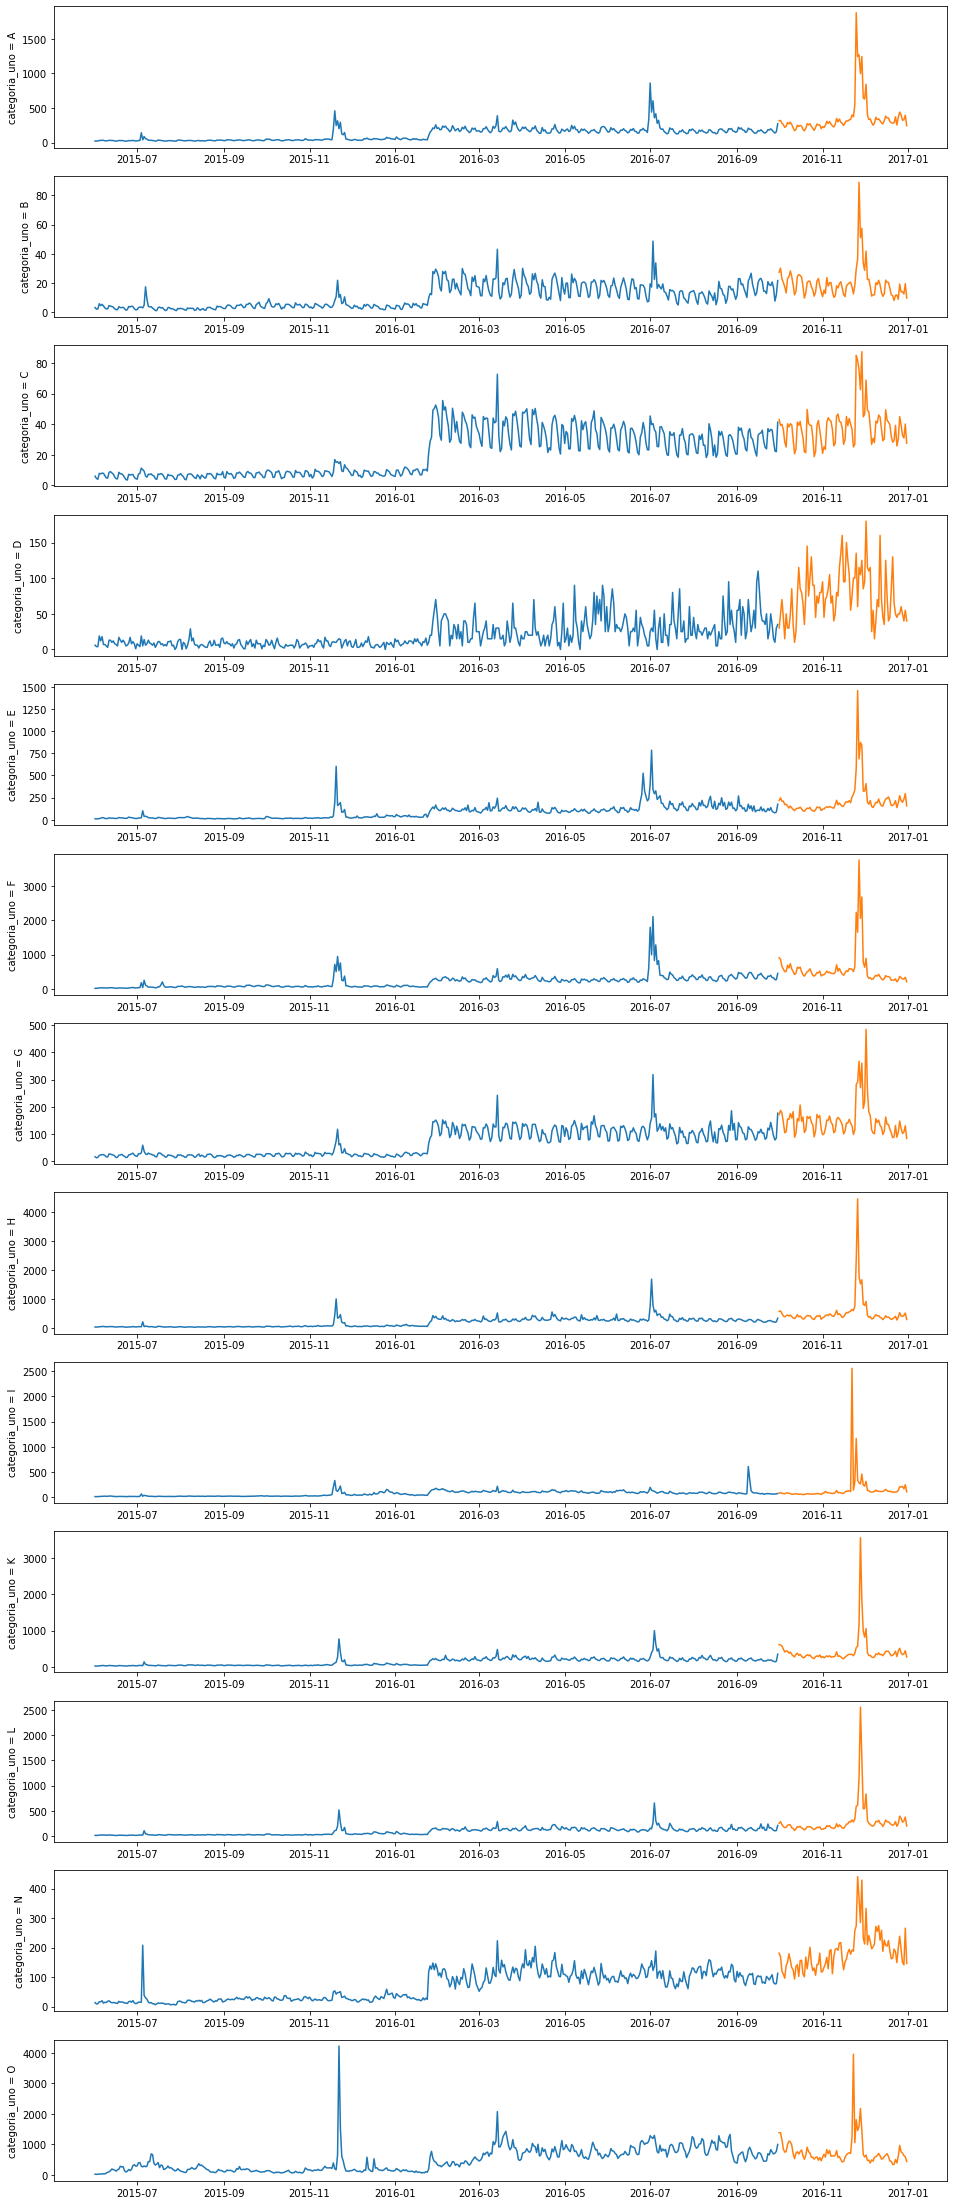

In [380]:
# Només visites, comparació Modelar vs Estimar
fig, axs = plt.subplots(figsize=(16,40), nrows=len(list_categoria_uno), ncols=1) #, gridspec_kw=dict(hspace=0.4))
for index in range(len(list_categoria_uno)):
    axs[index].plot(data_mean[index]["visitas"])
    axs[index].plot(data_est_mean[index]["visitas"])
#    axs[index].plot(data_mean[index]["unidades_vendidas"])
    axs[index].set(ylabel="categoria_uno = "+list_categoria_uno[index])
#    axs[index].set(xlim=(datetime.datetime(2016,1,15),datetime.datetime(2016,2,8)))

# Abans del 24/01/2016 i després del 25/01/2016

In [209]:
# El 25 de gener respecte el 24 haurien de baixar les visites pel dia de la setmana que és i pugen.
# Suma
data_sum[0][datetime.datetime(2016,1,21):datetime.datetime(2016,1,28)]

,id,visitas,categoria_dos,precio,dia_atipico,campaña,antiguedad,unidades_vendidas,estado_num,weekday
fecha,,,,,,,,,,
2016-01-21,342841338,67283,211777,39864.22,0,0,1328228,9288,1076,4158
2016-01-22,342841338,57569,211777,39880.13,0,0,1328228,6225,1060,5544
2016-01-23,342841338,61819,211777,39877.75,0,0,1328228,6144,1060,6930
2016-01-24,342841338,53368,211777,39885.83,0,0,1328228,5721,1081,8316
2016-01-25,342841338,139555,211777,39891.87,0,0,1328228,5145,1105,0
2016-01-26,342841338,207385,211777,39898.00,0,0,1328228,2598,1052,1386
2016-01-27,342841338,240455,211777,39905.24,0,0,1328228,2382,1044,2772
2016-01-28,342841338,293875,211777,39893.12,0,0,1328228,6648,1039,4158


In [210]:
# El 25 de gener respecte el 24 haurien de baixar les visites pel dia de la setmana que és i pugen.
# Mitjana
data_mean_total[datetime.datetime(2016,1,21):datetime.datetime(2016,1,28)]

,antiguedad,campaña,categoria_dos,dia_atipico,estado_num,id,precio,unidades_vendidas,visitas,weekday
fecha,,,,,,,,,,
2016-01-21,1074.461104,0.0,189.171676,0,0.758157,269635.433781,35.637999,4.905230,44.681862,3
2016-01-22,1074.461104,0.0,189.171676,0,0.745681,269635.433781,35.644424,3.952255,43.023273,4
2016-01-23,1074.461104,0.0,189.171676,0,0.755278,269635.433781,35.645513,4.004079,47.234645,5
2016-01-24,1074.461104,0.0,189.171676,0,0.755038,269635.433781,35.636144,3.740643,37.928503,6
2016-01-25,1074.461104,0.0,189.171676,0,0.771593,269635.433781,35.638184,2.977687,96.203215,0
2016-01-26,1074.461104,0.0,189.171676,0,0.731526,269635.433781,35.642385,1.747601,144.966411,1
2016-01-27,1074.461104,0.0,189.171676,0,0.722889,269635.433781,35.645022,1.535988,168.108205,2
2016-01-28,1074.461104,0.0,189.171676,0,0.718810,269635.433781,35.621766,4.086852,215.978887,3


In [211]:
# Vull agrupar per data, separar en abans del 25 de gener i després del 25 de gener i fer un groupby per dia de la setmana
data_mean_total_abans = data_mean_total[:datetime.datetime(2016,1,24)]
data_mean_total_despres = data_mean_total[datetime.datetime(2016,1,25):]

data_mean_total_abans_weekday = data_mean_total_abans.groupby('weekday').mean().sort_values('weekday')
data_mean_total_despres_weekday = data_mean_total_despres.groupby('weekday').mean().sort_values('weekday')

### Mitjana de visites abans i després

<AxesSubplot:xlabel='weekday'>

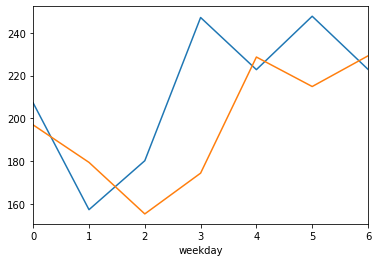

In [212]:
(data_mean_total_abans_weekday["visitas"]*4.5).plot()  # (Gràfica escalada!)
data_mean_total_despres_weekday["visitas"].plot()

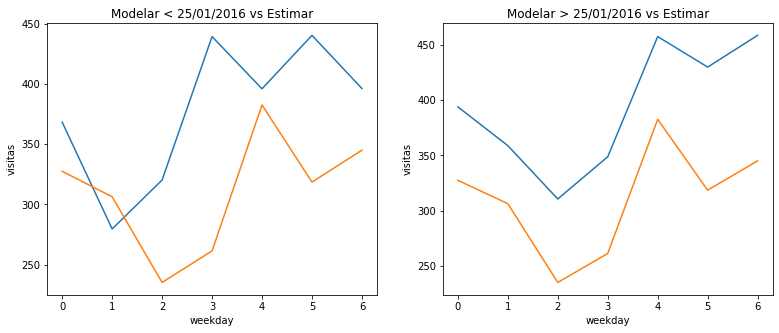

In [407]:
# Comparació de les visites de l'arxiu Estimar amb les de Modelar després del 25 de gener
data_est_mean_total_weekday = data_est_mean_total.groupby('weekday').mean().sort_values('weekday')
#data_est_mean_total_weekday["visitas"].plot()
#data_mean_total_despres_weekday["visitas"].plot()

fig, axs = plt.subplots(figsize=(13,5), nrows=1, ncols=2)
axs[0].set(xlabel="weekday",ylabel="visitas", title="Modelar < 25/01/2016 vs Estimar")
axs[1].set(xlabel="weekday",ylabel="visitas", title="Modelar > 25/01/2016 vs Estimar")

axs[0].plot(data_mean_total_abans_weekday["visitas"]*8)
axs[0].plot(data_est_mean_total_weekday["visitas"])

axs[1].plot(data_mean_total_despres_weekday["visitas"]*2)
axs[1].plot(data_est_mean_total_weekday["visitas"])

### Mitjana de compres abans i després

<AxesSubplot:xlabel='weekday'>

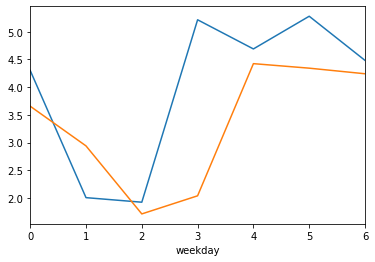

In [386]:
data_mean_total_abans_weekday["unidades_vendidas"].plot()
data_mean_total_despres_weekday["unidades_vendidas"].plot()

### Ràtio entre mitjana de visites i mitjana de compres abans i després

<AxesSubplot:xlabel='weekday'>

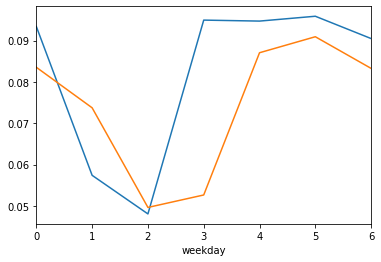

In [214]:
(data_mean_total_abans_weekday["unidades_vendidas"]/data_mean_total_abans_weekday["visitas"]).plot()
(4.5*data_mean_total_despres_weekday["unidades_vendidas"]/data_mean_total_despres_weekday["visitas"]).plot()
# (Gràfica escalada!)

### Visites vs vendes abans i després del 25/01/2016

Text(0, 0.5, 'unidades_vendidas')

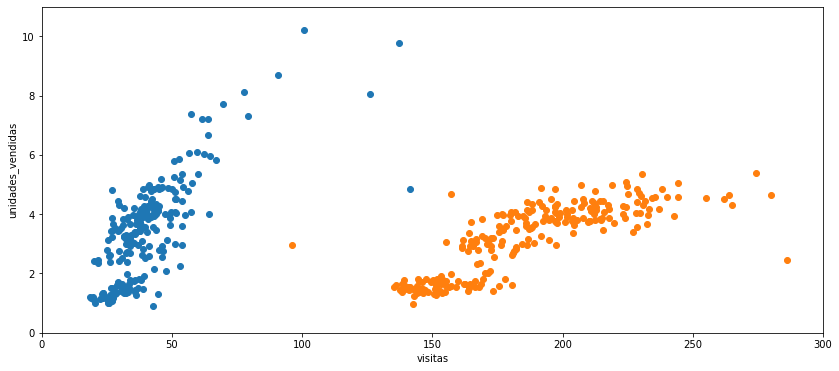

In [284]:
plt.figure(figsize=[14,6])
plt.scatter(data_mean_total_abans["visitas"], data_mean_total_abans["unidades_vendidas"])
plt.scatter(data_mean_total_despres["visitas"], data_mean_total_despres["unidades_vendidas"])
plt.xlim(0,300)
plt.ylim(0,11)
plt.xlabel("visitas")
plt.ylabel("unidades_vendidas")

# Días atípics

In [291]:
# Percentatge de dies típics
100*len(data_mean_tipics)/len(data_mean_total)

86.652977412731

<AxesSubplot:>

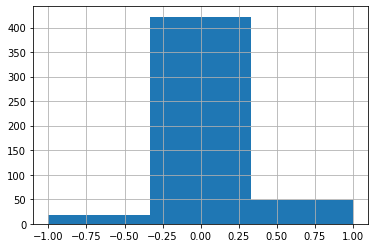

In [226]:
data_mean_total["dia_atipico"].hist(bins = 3)

### Visites i vendes en dies típics

In [216]:
df_tipics = df[df["dia_atipico"] == 0].copy()

In [232]:
data_sum_tipics = [None]*len(list_categoria_uno)
for index in range(len(list_categoria_uno)):
    data_sum_tipics[index] = df_tipics[df_tipics["categoria_uno"] == 
                         list_categoria_uno[index]].groupby('fecha').sum().sort_values('fecha')                         

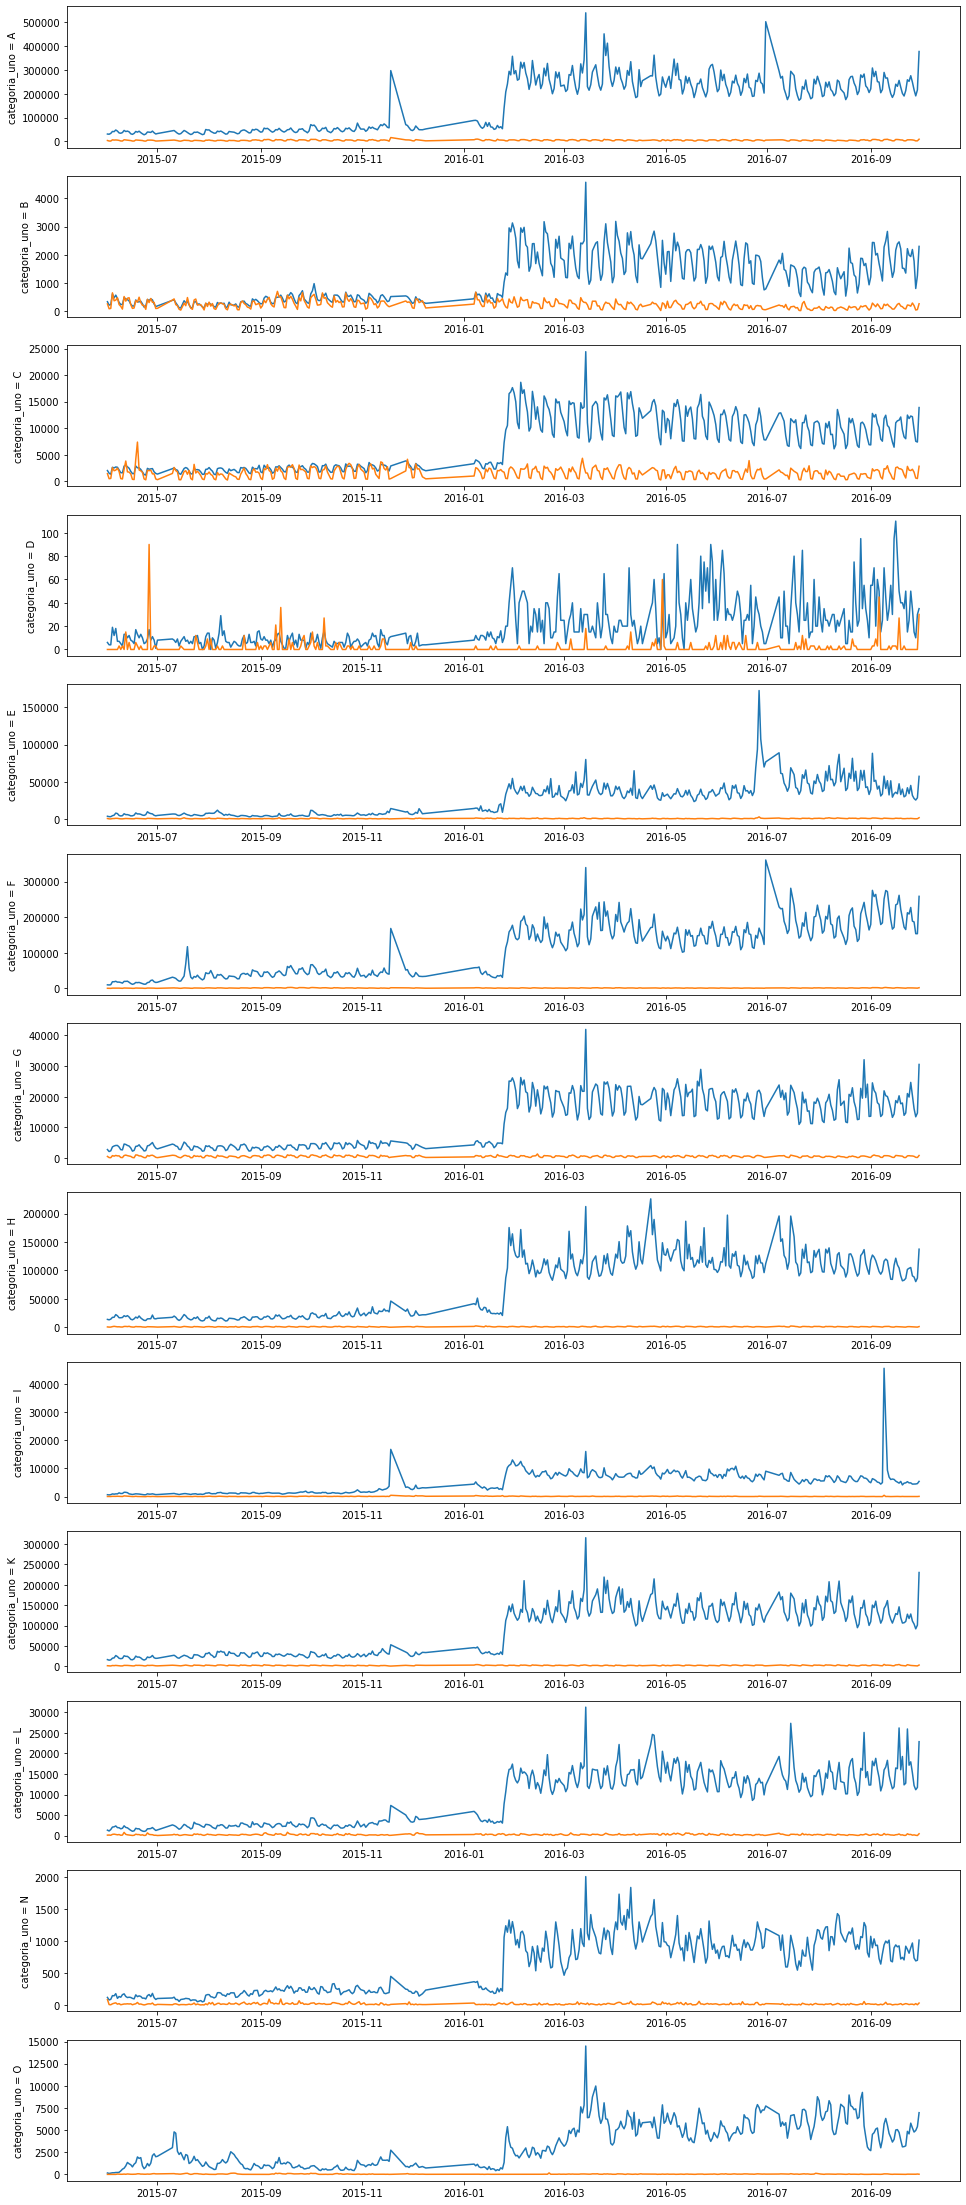

In [233]:
# Igual que abans però sense els dies atípics (Black Friday, Nadal, etc)
fig, axs = plt.subplots(figsize=(16,40), nrows=len(list_categoria_uno), ncols=1) #, gridspec_kw=dict(hspace=0.4))
for index in range(len(list_categoria_uno)):
    axs[index].plot(data_sum_tipics[index]["visitas"])
    axs[index].plot(data_sum_tipics[index]["unidades_vendidas"])
    axs[index].set(ylabel="categoria_uno = "+list_categoria_uno[index])
#    axs[index].set(xlim=(datetime.datetime(2016,1,15),datetime.datetime(2016,2,8)))

### Histograma de vendes per categoria

<AxesSubplot:>

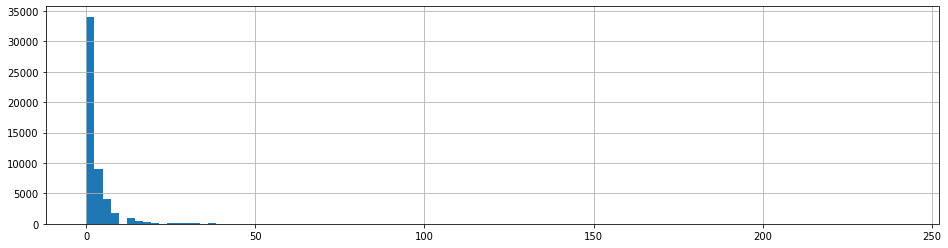

In [354]:
plt.figure(figsize=(16,4))
df["unidades_vendidas"][df["categoria_uno"]=="B"].hist(bins=100)

### Behaviour difference is not due to atypical days

In [234]:
data_mean_tipics = df_tipics.groupby('fecha').mean().sort_values('fecha')

In [235]:
# Vull agrupar per data, separar en abans del 24 de gener i després del 25 de gener i fer un groupby per dia de la setmana
data_mean_tipic_abans = data_mean_tipics[:datetime.datetime(2016,1,24)]
data_mean_tipic_despres = data_mean_tipics[datetime.datetime(2016,1,25):]

data_mean_tipic_abans_weekday = data_mean_tipic_abans.groupby('weekday').mean().sort_values('weekday')
data_mean_tipic_despres_weekday = data_mean_tipic_despres.groupby('weekday').mean().sort_values('weekday')

<AxesSubplot:xlabel='weekday'>

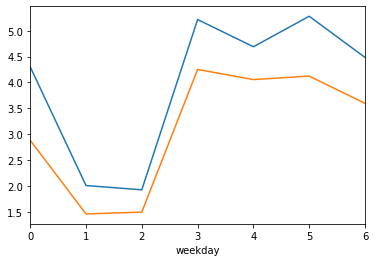

In [242]:
data_mean_total_abans_weekday["unidades_vendidas"].plot()
data_mean_tipic_abans_weekday["unidades_vendidas"].plot()

<AxesSubplot:xlabel='weekday'>

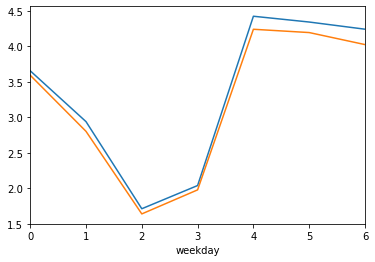

In [244]:
data_mean_total_despres_weekday["unidades_vendidas"].plot()
data_mean_tipic_despres_weekday["unidades_vendidas"].plot()

<AxesSubplot:xlabel='weekday'>

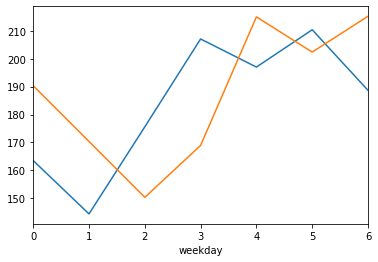

In [250]:
# (Gràfica reescalada!)
(data_mean_tipic_abans_weekday["visitas"]*5).plot()
data_mean_tipic_despres_weekday["visitas"].plot()

<AxesSubplot:xlabel='weekday'>

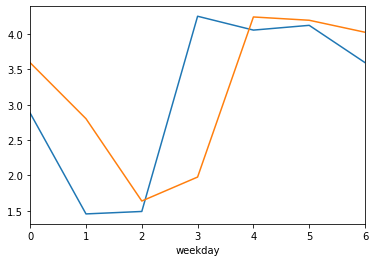

In [245]:
data_mean_tipic_abans_weekday["unidades_vendidas"].plot()
data_mean_tipic_despres_weekday["unidades_vendidas"].plot()

# Antiguedad

<AxesSubplot:>

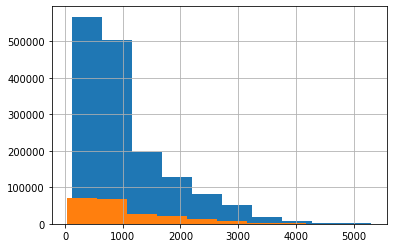

In [351]:
# Modelar dataset
# Rang dates 1/6/2015-30/9/2016 (487 dies)
# Rang antiguedad 126-5310 dies (5184 dies)

# Estimar dataset
# Rang dates 1/10/2016-31/12/2016 (91 dies)
# Rang antiguedad 35-5219 dies (5184 dies)

#df.fecha.max()-df.fecha.min()  # 487 dies
#df.antiguedad.max()-df.antiguedad.min()   # 5310 -126 = 5184 dies
df.antiguedad.hist(bins=10)

#df_est.fecha.max()-df_est.fecha.min()  # 91 dies
#df_est.antiguedad.max()-df_est.antiguedad.min()    # 5219 - 35 = 5184
df_est.antiguedad.hist(bins=10)

<AxesSubplot:>

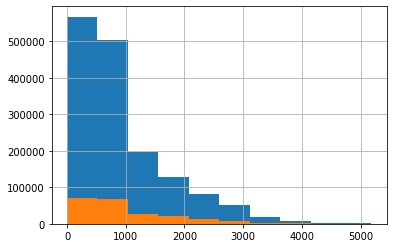

In [352]:
df.antiguedad_std.hist()
df_est.antiguedad_std.hist()

## Arxiu "Estimar" és un subconjunt del "Modelar"

In [410]:
print(len(np.setdiff1d(df.id.unique(),df_est.id.unique())))  # Unique values in array 1, not in array 2 = 1274
print(len(np.setdiff1d(df_est.id.unique(),df.id.unique())))  # Unique values in array 2, not in array 1 = 0

#len(df_est.id.unique())  # 2894
#len(df.id.unique())  # 4168
len(df.id.unique())-len(df_est.id.unique())   # Conclusió: array 2 és un subconjunt de l'array 1

1274
0


1274

## Feature Engineering and data cleaning

### Improved antiguedad feature (products get older with every day)

In [139]:
df["day_interval"] = df["fecha"]-df.fecha.min()  #dies que han passat
df["antiguedad_evo"] = df["antiguedad_std"] + df["day_interval"].astype(int)/(3600*24*10e8)

df_est["day_interval"] = df_est["fecha"]-df.fecha.min()  #dies que han passat
df_est["antiguedad_evo"] =  df_est["antiguedad_std"] + df_est["day_interval"].astype(int)/(3600*24*10e8)

<AxesSubplot:>

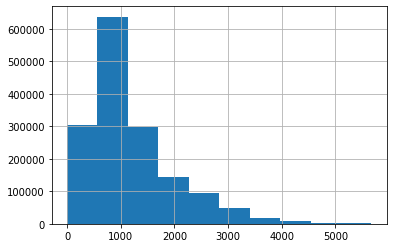

In [141]:
df.antiguedad_evo.hist()

<AxesSubplot:>

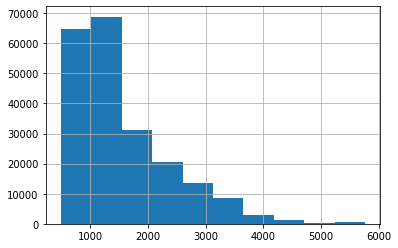

In [140]:
df_est.antiguedad_evo.hist()

### Vendes per categoria normalitzades 

In [256]:
dataA_norm = dataA.unidades_vendidas / dataA.unidades_vendidas.mean()
dataB_norm = dataB.unidades_vendidas / dataB.unidades_vendidas.mean()
dataC_norm = dataC.unidades_vendidas / dataC.unidades_vendidas.mean()
dataD_norm = dataD.unidades_vendidas / dataD.unidades_vendidas.mean()
dataE_norm = dataE.unidades_vendidas / dataE.unidades_vendidas.mean()
dataF_norm = dataF.unidades_vendidas / dataF.unidades_vendidas.mean()
dataG_norm = dataG.unidades_vendidas / dataG.unidades_vendidas.mean()
dataH_norm = dataH.unidades_vendidas / dataH.unidades_vendidas.mean()
dataI_norm = dataI.unidades_vendidas / dataI.unidades_vendidas.mean()
dataK_norm = dataK.unidades_vendidas / dataK.unidades_vendidas.mean()
dataL_norm = dataL.unidades_vendidas / dataL.unidades_vendidas.mean()
dataN_norm = dataN.unidades_vendidas / dataN.unidades_vendidas.mean()
dataO_norm = dataO.unidades_vendidas / dataO.unidades_vendidas.mean()

<AxesSubplot:xlabel='fecha'>

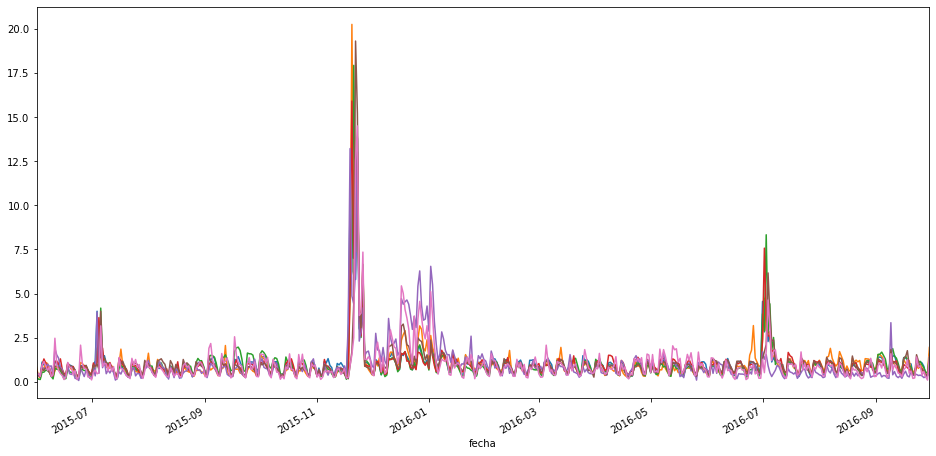

In [306]:
plt.figure(figsize=[16,8])

dataA_norm.plot()  # black friday
#dataB_norm.plot()
#dataC_norm.plot()
#dataD_norm.plot()
dataE_norm.plot()  # black friday
dataF_norm.plot()  # black friday
#dataG_norm.plot()
dataH_norm.plot()
dataI_norm.plot()     # black friday i Nadal
dataK_norm.plot()  # black friday
dataL_norm.plot()  # black friday i Nadal
#dataN_norm.plot()
#dataO_norm.plot()

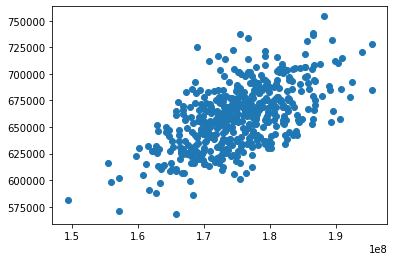

In [123]:
plt.scatter(data["id"],data["antiguedad"])